In [129]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

### RENS Analysis

* Plot work distribution

In [130]:
file_loc = '../../runs/rens_13'

In [131]:
exchanges = pd.read_csv(os.path.join(file_loc, 'exchanges.txt'), sep = ',')

In [132]:
W_A = exchanges['W_A']
W_B = exchanges['W_B']

In [133]:
def pot_energy(x):
    if x < -1.25:
        return (4 * (np.pi**2)) * (x + 1.25)**2
    
    if x >= -1.25 and x <= -0.25:
        return 2 * (1 + np.sin(2 * np.pi * x))
        
    if x >= -0.25 and x <= 0.75:
        return 3 * (1 + np.sin(2 * np.pi * x))
                  
    if x >= 0.75 and x <= 1.75:
        return 4 * (1 + np.sin(2 * np.pi * x))
                  
    # if x >= 1.75:
    return 8 * (np.pi**2) * ((x - 7 / 4) ** 2)

In [134]:
def free_energy(N, T):
    from scipy.integrate import quad
    kB = 1
    beta = 1 / (kB * T)
    Z_single_particle = quad(lambda x : np.exp(-beta * pot_energy(x)), -np.inf, np.inf)[0]
    f = -N * np.log(Z_single_particle)
    f -= (N/
          2) * np.log(2 * np.pi / beta)
    return f

In [135]:
f_A = free_energy(10, 2.0)
f_B = free_energy(10, 0.3)

In [136]:
free = f_B - f_A

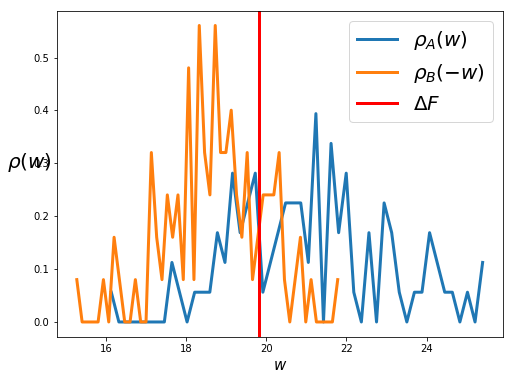

In [137]:
fig = plt.figure(figsize = (8, 6))
p, be = np.histogram(W_A, bins = 50, density = True)
coords = (be[1:] + be[:-1])/2
plt.plot(coords, p, lw = 3, label = r'$\rho_A (w)$')

p, be = np.histogram(W_B, bins = 50, density = True)
coords = (be[1:] + be[:-1]) / 2
plt.plot(-coords, p, lw = 3, label = r'$\rho_B (-w)$')

plt.axvline(x = free, color = 'red', lw = 3, label = r'$\Delta F$')
plt.legend(loc = 'best', fontsize = 20)
plt.xlabel(r'$w$', fontsize = 15)
y = plt.ylabel(r'$\rho (w)$', fontsize = 20)
y.set_rotation(0)

### Obtaining following values for all RENS simulations performed : 
* w_mean
* \<p_acc\>
* X = $\tau$ / $\tau_{eq}$
* t_c = (1 / $\sigma^2$) * c(t), where c(t) = Autocorrelation of $n_4(t)$
* f_sw = X / (1 + X)
* M = no of replicas
* t* = (1 + X) * M * t_c

* w_mean, p_acc

In [138]:
w = W_A + W_B
w_mean = w.mean()

In [139]:
p_acc = exchanges['Exchanged'].mean()

In [140]:
w_mean, p_acc

(2.3656851495621356, 0.2978723404255319)

* X, tau_eq, f_sw

In [141]:
tau = 2.0
dt = 1e-3
num_steps = int(1e7)
final_time = num_steps * dt
k = exchanges['Time'].to_numpy()

In [142]:
ending_points = k - tau
ending_points = np.insert(ending_points, ending_points.size, final_time)
k = np.insert(k, 0, 0)

In [143]:
tau_eq = ending_points - k
tau_eq = tau_eq.mean()

In [144]:
X = tau / tau_eq
f_sw = X / (1 + X)
M = 2

In [145]:
X, tau_eq, f_sw

(0.01936404402772116, 103.28421052631579, 0.01899620075984803)

* t_c, t_star

In [146]:
pos = np.loadtxt(os.path.join(file_loc, '0/p.txt'))
# ind = np.where(pos[:, -1] == 0)
steps = pos[:, 0]
mode = pos[:, -1]
pos = pos[:, 1:-1]

In [147]:
pos.shape

(100000, 10)

In [148]:
ind = mode == 0
n_4t = np.sum(pos[ind, :] >= 1.25, axis = 1)

In [149]:
n_4t.shape

(5565,)

In [150]:
def auto_corr(x, tau):
    len_data = len(x[tau:])
    mean = x.mean()
    num = (x[:len_data] * x[tau:tau + len_data]).mean() - mean**2
    var = (x**2).mean() - (mean)**2
    return num / var

In [151]:
c_t = np.array([auto_corr(n_4t, i) for i in range(n_4t.size)])

In [159]:
c_t.size

5565

In [160]:
c_t_half = c_t[:c_t.size//2]
# S_2 = c_t_half[32000:].mean()
# print(S_2)
# c_t_half = (c_t_half - S_2) / (1 - S_2) 

In [161]:
steps
dt = steps[1] - steps[0]

In [162]:
dt

0.1

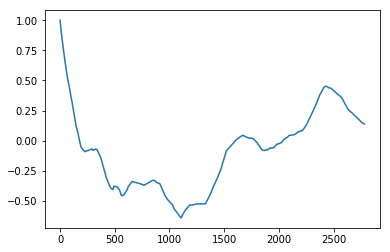

In [163]:
plt.plot(c_t_half)

In [166]:
block_size = 100
dt_new = dt * block_size
c_t_block = np.array([c_t_half[i:i + block_size].mean() for i in range(0, c_t_half.size, block_size)])
c_t_block /= c_t_block[0]

-3.8012965423240193


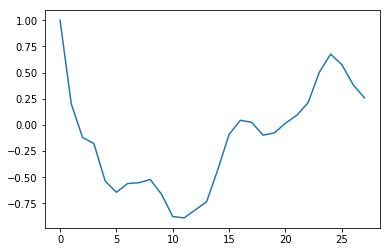

In [167]:
print(c_t_block.sum())
plt.plot(c_t_block)

In [168]:
t_c = 2 * c_t_block.sum() * dt_new

In [169]:
t_star = (1 + X) * M * t_c

In [170]:
t_c, t_star

(-76.02593084648038, -154.99620063728023)

## Multiple probs

In [25]:
pos = np.loadtxt(os.path.join(file_loc, '0/p.txt'))
ind = np.where(pos[:, -1] == 0)[0]
steps = pos[ind, 0]
mode = pos[ind, -1]
pos = pos[ind, 1:-1]

In [26]:
interval = 10000

In [27]:
bins = [-np.inf, -0.75, 0.25, 1.25, np.inf]


In [28]:
boltzmann_integrand = np.empty(len(bins) - 1)

In [29]:
from scipy.integrate import quad
beta = 1 / 0.3
for i in wells:
    boltzmann_integrand[i - 1] = quad(lambda x: np.exp(-beta * pot_energy(x)), bins[i-1], bins[i])[0]

NameError: name 'wells' is not defined

In [ ]:
boltzmann_integrand /= boltzmann_integrand.sum()

In [ ]:
boltzmann_integrand

In [ ]:
# steps.shape
pos.shape[0]

In [ ]:
h = interval
i = 0
l = []
t = []
while h < pos.shape[0]:
    p, _ = np.histogram(pos[:h, 0], bins = bins)
    p = p.astype('float')
    p /= p.sum()
    l.append(p)
    i += 1
    h += interval
    print(h, steps.shape[0])
    
    t.append(steps[min(steps.shape[0] - 1, h)])
    print(t[-1])
l = np.array(l)
colors = ['r', 'g', 'b', 'm']
markers=["+", "x", "o", "s"]

for i in range(4):
    plt.scatter(t, l[:, i], marker = markers[i], color=colors[i])
    plt.axhline(y = boltzmann_integrand[i], color = colors[i])

plt.xlabel('Time (s)')
_ = plt.ylabel('Prob.')
_.set_rotation(0)

In [ ]:
steps